In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
import seaborn as sns
# 한글
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm , rc
font = fm.FontProperties(fname='C:\Windows\Fonts/gulim.ttc').get_name()
#셀레니움
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium import webdriver
from bs4 import BeautifulSoup as bs
import time


# 10_11_분석기획
## 1. 액티브_휴폐업_오버뷰로 재무데이터 머지 해보기
## 2. 산업분류를 이용하여 업종별 라벨링 후 해당기간 대장주 불러오기
-> 마리아 디비 사용여부 고민

-> 기간별로 하나파일로 합쳐도 괜찮을지도...?

In [2]:
nb_codzip = pd.read_excel('넘블 챌린지 개방데이터 코드집.xlsx', sheet_name=0)
nb_codzip_finance = pd.read_excel('넘블 챌린지 개방데이터 코드집.xlsx', sheet_name=1)
nb_layout = pd.read_excel('넘블 챌린지 개방데이터 레이아웃.xlsx')
nb_active_out = pd.read_excel('액티브 중소법인 재무보유.xlsx', sheet_name=0)
nb_active_overview = pd.read_excel('액티브 중소법인 재무보유.xlsx', sheet_name=1)
nb_active_oclog = pd.read_excel('액티브 중소법인 재무보유.xlsx', sheet_name=2)
nb_deactive_overview = pd.read_excel('휴폐업 중소법인 재무보유.xlsx', sheet_name=0)
nb_deactive_oclog = pd.read_excel('휴폐업 중소법인 재무보유.xlsx', sheet_name=1)
nb_finance_data = pd.read_csv('재무데이터.txt', encoding='cp949', sep='\t')


In [3]:
nb_active_ind = pd.read_excel('액티브_중소법인_기업개요_산업분류.xlsx')
nb_deactive_ind = pd.read_excel('휴폐업_중소법인_기업개요_산업분류.xlsx')

## 1. 액티브_휴폐업_오버뷰로 재무데이터 머지 해보기

In [4]:
nb_active_overview.head()

,BIZ_NO,CMP_PFIX_NM,CMP_NM,CMP_NM1,CMP_SFIX_NM,CMP_ENM,BZ_TYP,CMP_TYP,CMP_SCL,PBCO_GB,...,TAXN_TYP,HDOF_CMP_CD,ESTB_DATE,ESTB_GB,LIST_DATE,MN_BIZ_CONT,NATN_NM,HOMEPAGE_URL,CEO_NM,EMP_CNT
0,2218116923,NaN,NaN,신우종합건설,(주),"Shinu General Construction Co., Ltd.",M,4,2,2,...,3.0,NaN,20000807.0,1.0,NaN,토목공사업,NaN,NaN,김주대외 1명,12.0
1,1138111739,NaN,한일가스산업(주),한일가스산업,(주),"HANIL GAS IND. CO.,LTD.",M,3,2,2,...,3.0,NaN,19660419.0,1.0,NaN,LP Gas 충전 및 판매업,NaN,www.hanilgas.com,홍순철외 1명,43.0
2,1108146490,(주),NaN,랩솔루션,NaN,Lab Solution,M,4,2,2,...,3.0,NaN,20000612.0,1.0,NaN,기체분석기 등,NaN,www.lab-solution.com,김봉철,3.0
3,3128134737,(주),NaN,고려인삼제품공사,NaN,"KOREAN GINSENG PRODUCT CO., LTD",M,4,2,2,...,3.0,NaN,19920301.0,1.0,NaN,"다류, 차, 인삼제품, 음료, 코코아가공품, 커피",NaN,www.kitea.co.kr,박경출,24.0
4,2078132193,(주),(주)엠피아이,엠피아이,NaN,"EMPIALEE CO.,LTD.",M,3,2,2,...,3.0,NaN,19910806.0,1.0,NaN,가죽 및 대용가죽제품 제조업,NaN,www.mastercnd.co.kr,이스테판상수외 1명,35.0


In [10]:
nb_active_overview[['BIZ_NO']]

,BIZ_NO
0,2218116923
1,1138111739
2,1108146490
3,3128134737
4,2078132193
...,...
198646,6208701973
198647,3688702720
198648,4868602701
198649,2528101633


In [11]:
nb_active_out[['BIZ_NO']]

,BIZ_NO
0,1138111739
1,2078132193
2,1318167565
3,5048128251
4,1098164260
...,...
28977,8048101453
28978,8028701430
28979,4268501421
28980,6518502462


In [168]:
nb_deactive_overview[['BIZ_NO']]

,BIZ_NO
0,1268145633
1,1388101749
2,1068179240
3,2248114507
4,1168132785
...,...
6734,4808501629
6735,8018501578
6736,4118523419
6737,1738102533


In [24]:
# 외감데이터는 오버뷰의 일부의 자세한 데이터!
act_biz = list(np.unique(pd.concat([nb_active_out[['BIZ_NO']], nb_active_overview[['BIZ_NO']]]).BIZ_NO.values))
len(act_biz)

198651

In [34]:
# 액티브 오버뷰 추출
nb_active_overview['target'] = 'N'
active_target = nb_active_overview[['BIZ_NO', 'target']]

In [35]:
# 휴폐업 오버뷰 추출
nb_deactive_overview['target'] = 'Y'
deactive_target = nb_deactive_overview[['BIZ_NO', 'target']]

In [46]:
temp1 = pd.merge(nb_finance_data, nb_active_overview[['BIZ_NO', 'target']], how='left', left_on='사업자번호', right_on='BIZ_NO')
target_merge = pd.merge(temp1, nb_deactive_overview[['BIZ_NO', 'target']], how='left', left_on='사업자번호', right_on='BIZ_NO')
target_merge

,사업자번호,결산년월,유동자산,매출채권,비유동자산,유형자산,자산총계,유동부채,비유동부채,부 채 총 계,...,매출채권회전율(회),매입채무회전율(회),미수금,매출원가,무형자산,재고자산,BIZ_NO_x,target_x,BIZ_NO_y,target_y
0,1018100340,20181231,2667731.0,127320.0,32346444.0,1179096.0,35014174.0,422872.0,16176067.0,16598939.0,...,4.406200e+01,1.000000e+12,NaN,NaN,NaN,NaN,1.018100e+09,N,NaN,NaN
1,1018100340,20191231,2168837.0,94085.0,34151633.0,1209369.0,36320470.0,10553878.0,5240445.0,15794323.0,...,5.909200e+01,NaN,NaN,NaN,NaN,NaN,1.018100e+09,N,NaN,NaN
2,1018100340,20201231,2272260.0,78612.0,38329680.0,1091153.0,40601940.0,863144.0,15496117.0,16359261.0,...,6.871400e+01,1.000000e+12,NaN,NaN,NaN,NaN,1.018100e+09,N,NaN,NaN
3,1018100340,20211231,1175030.0,273522.0,37135811.0,993025.0,38310842.0,9494272.0,4901383.0,14395654.0,...,3.497900e+01,1.000000e+12,3243.0,NaN,NaN,NaN,1.018100e+09,N,NaN,NaN
4,1018100772,20181231,422146.0,17011.0,20370096.0,20352846.0,20792242.0,2684934.0,11404637.0,14089571.0,...,6.971100e+01,1.000000e+12,386880.0,524746.0,NaN,NaN,1.018101e+09,N,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109137,8998800427,20211231,9192992.0,2918329.0,9735232.0,9409374.0,18928223.0,11017981.0,6619380.0,17637362.0,...,7.950000e+00,9.792000e+00,331735.0,23370771.0,75451.0,3680509.0,8.998800e+09,N,NaN,NaN
109138,8998800785,20181231,3608435.0,NaN,271541001.0,271541001.0,275149436.0,164335821.0,76480438.0,240816259.0,...,1.000000e+12,1.000000e+12,NaN,NaN,NaN,NaN,8.998801e+09,N,NaN,NaN
109139,8998800785,20191231,475283.0,NaN,309796969.0,309796969.0,310272251.0,3722434.0,274776917.0,278499351.0,...,1.000000e+12,1.000000e+12,NaN,NaN,NaN,NaN,8.998801e+09,N,NaN,NaN
109140,8998800785,20201231,1474607.0,NaN,366181956.0,366181956.0,367656563.0,1593683.0,335844394.0,337438077.0,...,1.000000e+12,1.000000e+12,NaN,NaN,NaN,NaN,8.998801e+09,N,NaN,NaN


In [47]:
target_merge.target_x.fillna('', inplace=True)
target_merge.target_y.fillna('', inplace=True)
target_merge ['target'] = target_merge.target_x + target_merge.target_y
target_merge ['target']

0         N
1         N
2         N
3         N
4         N
         ..
109137    N
109138    N
109139    N
109140    N
109141    N
Name: target, Length: 109142, dtype: object

In [48]:
target_merge[['target']].value_counts()

target
N         98905
Y         10237
dtype: int64

In [49]:
fn_drop = target_merge.drop(target_merge[target_merge.target == ''].index)
fn_drop = fn_drop[fn_drop.columns.drop(['BIZ_NO_x', 'target_x', 'BIZ_NO_y', 'target_y', '사업자번호', '결산년월'])]
fn_drop

,유동자산,매출채권,비유동자산,유형자산,자산총계,유동부채,비유동부채,부 채 총 계,자본금,이익잉여금(결손금）,...,부채총계대 매출액(%),총자본회전율(회),재고자산회전율(회),매출채권회전율(회),매입채무회전율(회),미수금,매출원가,무형자산,재고자산,target
0,2667731.0,127320.0,32346444.0,1179096.0,35014174.0,422872.0,16176067.0,16598939.0,721100.0,3859072.0,...,2.503810e+02,1.630000e-01,1.000000e+12,4.406200e+01,1.000000e+12,NaN,NaN,NaN,NaN,N
1,2168837.0,94085.0,34151633.0,1209369.0,36320470.0,10553878.0,5240445.0,15794323.0,721100.0,3708092.0,...,2.414000e+02,1.840000e-01,1.000000e+12,5.909200e+01,NaN,NaN,NaN,NaN,NaN,N
2,2272260.0,78612.0,38329680.0,1091153.0,40601940.0,863144.0,15496117.0,16359261.0,721100.0,4230449.0,...,2.757190e+02,1.540000e-01,1.000000e+12,6.871400e+01,1.000000e+12,NaN,NaN,NaN,NaN,N
3,1175030.0,273522.0,37135811.0,993025.0,38310842.0,9494272.0,4901383.0,14395654.0,721100.0,5169522.0,...,2.337490e+02,1.560000e-01,1.000000e+12,3.497900e+01,1.000000e+12,3243.0,NaN,NaN,NaN,N
4,422146.0,17011.0,20370096.0,20352846.0,20792242.0,2684934.0,11404637.0,14089571.0,52000.0,-7410129.0,...,1.250082e+03,5.500000e-02,1.000000e+12,6.971100e+01,1.000000e+12,386880.0,524746.0,NaN,NaN,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109137,9192992.0,2918329.0,9735232.0,9409374.0,18928223.0,11017981.0,6619380.0,17637362.0,514500.0,-1183183.0,...,7.009100e+01,1.477000e+00,6.785000e+00,7.950000e+00,9.792000e+00,331735.0,23370771.0,75451.0,3680509.0,N
109138,3608435.0,NaN,271541001.0,271541001.0,275149436.0,164335821.0,76480438.0,240816259.0,37780000.0,-3315168.0,...,1.000000e+12,1.000000e+12,1.000000e+12,1.000000e+12,1.000000e+12,NaN,NaN,NaN,NaN,N
109139,475283.0,NaN,309796969.0,309796969.0,310272251.0,3722434.0,274776917.0,278499351.0,37780000.0,-5875445.0,...,8.888889e+11,0.000000e+00,1.000000e+12,1.000000e+12,1.000000e+12,NaN,NaN,NaN,NaN,N
109140,1474607.0,NaN,366181956.0,366181956.0,367656563.0,1593683.0,335844394.0,337438077.0,37780000.0,-7429859.0,...,8.888889e+11,0.000000e+00,1.000000e+12,1.000000e+12,1.000000e+12,NaN,NaN,NaN,NaN,N


In [50]:
fn_drop.dtypes

유동자산            float64
매출채권            float64
비유동자산           float64
유형자산            float64
자산총계            float64
유동부채            float64
비유동부채           float64
부  채  총  계      float64
자본금             float64
이익잉여금(결손금）      float64
자본총계            float64
매출액             float64
판매비와관리비         float64
영업이익（손실）        float64
법인세비용차감전순손익     float64
법인세비용           float64
당기순이익(손실)       float64
기업순이익률(%)       float64
유보액/총자산(%)      float64
유보액/납입자본(%)     float64
매출액총이익률(%)      float64
매출액영업이익률(%)     float64
매출액순이익률(%)      float64
수지비율(%)         float64
경상수지비율          float64
영업비율(%)         float64
금융비용대매출액비율(%    float64
금융비용대부채비율(%)    float64
금융비용대총비용비율(%    float64
부채비율(%)         float64
차입금의존도(%)       float64
자기자본비율(%)       float64
순운전자본비율(%)      float64
유동부채비율(%)       float64
비유동부채비율(%)      float64
부채총계대 매출액(%)    float64
총자본회전율(회)       float64
재고자산회전율(회)      float64
매출채권회전율(회)      float64
매입채무회전율(회)      float64
미수금             float64
매출원가            

In [51]:
fn_drop.isna().sum()

유동자산              999
매출채권            18010
비유동자산            2025
유형자산             7244
자산총계              989
유동부채             1144
비유동부채           11260
부  채  총  계       1070
자본금              1029
이익잉여금(결손금）       1273
자본총계              997
매출액              5408
판매비와관리비          1375
영업이익（손실）         1096
법인세비용차감전순손익      1280
법인세비용           35684
당기순이익(손실)        1049
기업순이익률(%)          33
유보액/총자산(%)        127
유보액/납입자본(%)       133
매출액총이익률(%)        660
매출액영업이익률(%)       659
매출액순이익률(%)        661
수지비율(%)           159
경상수지비율           5277
영업비율(%)           659
금융비용대매출액비율(%     2135
금융비용대부채비율(%)       94
금융비용대총비용비율(%     1743
부채비율(%)           121
차입금의존도(%)         376
자기자본비율(%)         119
순운전자본비율(%)        119
유동부채비율(%)         132
비유동부채비율(%)        993
부채총계대 매출액(%)      624
총자본회전율(회)          15
재고자산회전율(회)         14
매출채권회전율(회)       2068
매입채무회전율(회)       3376
미수금             27548
매출원가            17769
무형자산            53849
재고자산            29366
target              0
dtype: int

In [52]:
for var in fn_drop.columns[:-1] :
    fn_drop[var].fillna(fn_drop[var].mean(), inplace=True)
fn_drop.isna().sum().sum()

0

In [59]:
# 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(fn_drop[fn_drop.columns[:-1]], fn_drop[fn_drop.columns[-1]],test_size=0.2, stratify=fn_drop.target, random_state=2022)
len(X_train), len(X_test), len(y_train), len(y_test)

(87313, 21829, 87313, 21829)

In [57]:
# 스케일 데이터 나누기
scaler = MinMaxScaler()
fn_temp = scaler.fit_transform(fn_drop[fn_drop.columns[:-1]])
X_train_sc, X_test_sc, y_train, y_test = train_test_split(fn_temp, fn_drop[fn_drop.columns[-1]],test_size=0.2, stratify=fn_drop.target, random_state=2022)
len(X_train_sc), len(X_test_sc), len(y_train), len(y_test)

(87313, 21829, 87313, 21829)

0.9529066837692978


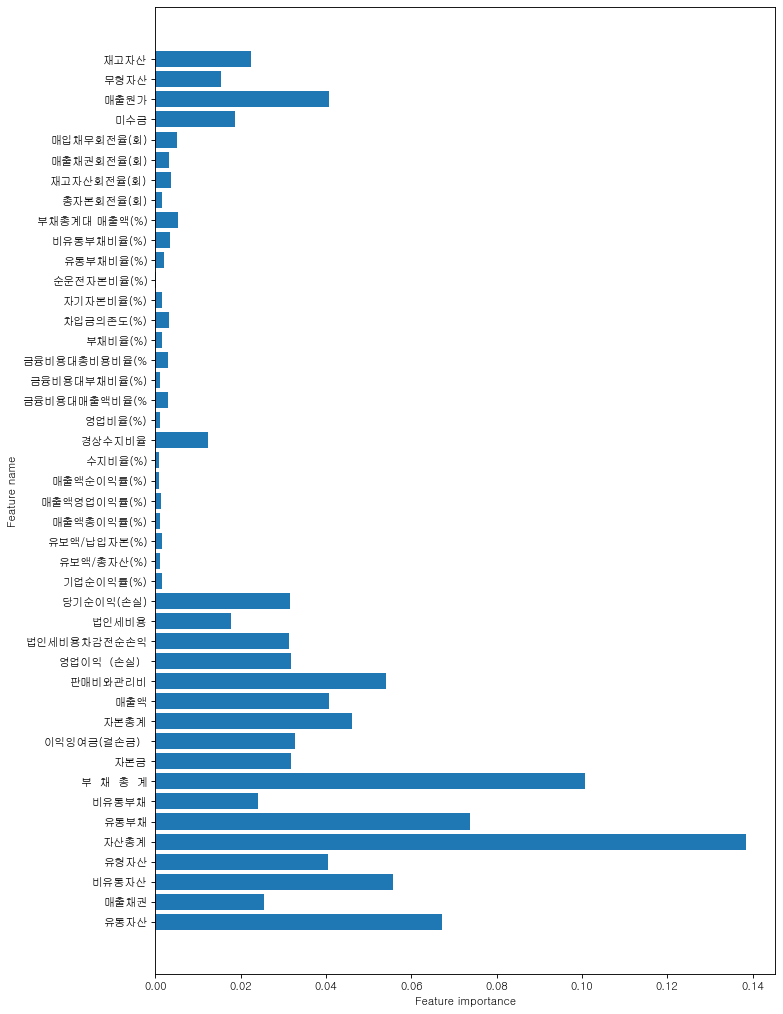

In [60]:
# rfc 스케일링 데이터
rfc_sc = RandomForestClassifier(random_state=2022).fit(X_train_sc, y_train)
print(rfc_sc.score(X_test_sc, y_test))
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm , rc
font = fm.FontProperties(fname='C:\Windows\Fonts/gulim.ttc').get_name()
rc('font', family=font)
plt.figure(figsize=(10,16), dpi=80)
c_features = len(X_train.columns)
plt.barh(range(c_features), rfc_sc.feature_importances_)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(c_features), X_train.columns)
plt.show()

In [61]:
rfc_sc.classes_

array(['N', 'Y'], dtype=object)

<AxesSubplot:>

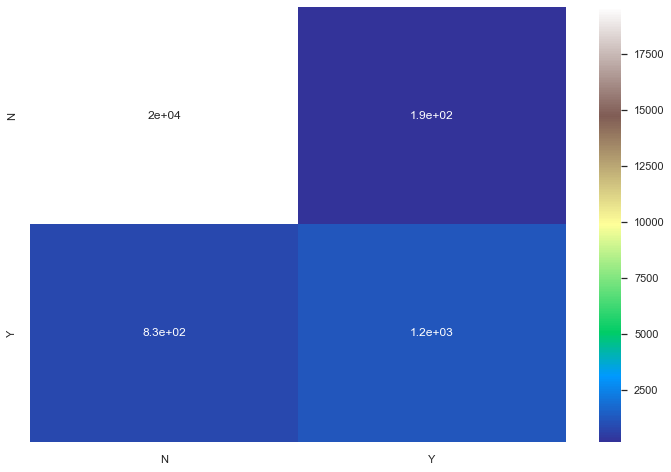

In [66]:
c = fn_drop.target.astype('category')
targets = dict(enumerate(c.cat.categories))
from sklearn.metrics import confusion_matrix
mat=confusion_matrix(y_test,rfc_sc.predict(X_test_sc))
df_cm = pd.DataFrame(mat, list(targets.values()), list(targets.values()))
sns.set(font_scale=1.0) # for label size
plt.figure(figsize = (12,8))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12},cmap="terrain")

In [69]:
f1_score(y_test,rfc_sc.predict(X_test_sc), pos_label='Y')

0.702374059061957

In [73]:
nb_active_ind.ind_01_cate.unique()

array(['건설업', '도매 및 소매업', '제조업', '정보통신업', '사업시설 관리, 사업 지원 및 임대 서비스업',
       '운수 및 창고업', '전문, 과학 및 기술 서비스업', '숙박 및 음식점업', '부동산업',
       '수도, 하수 및 폐기물 처리, 원료 재생업', '금융 및 보험업', '예술, 스포츠 및 여가관련 서비스업',
       '협회 및 단체, 수리 및 기타 개인 서비스업', '공공 행정, 국방 및 사회보장 행정', '교육 서비스업',
       '전기, 가스, 증기 및 공기 조절 공급업', '보건업 및 사회복지 서비스업', nan,
       '가구 내 고용활동 및 달리 분류되지 않은 자가 소비 생산활동', '국제 및 외국기관'], dtype=object)

In [74]:
ind_01_dict = {}
for ind in ['01', '02', '03']:
    ind_01_dict[ind] = '농업, 임업 및 어업'
for ind in ['05', '06', '07', '08'] : 
    ind_01_dict[ind] = '광업'
for ind in range(10, 35):
    ind_01_dict[str(ind)] = '제조업'
for ind in range(35, 36):
    ind_01_dict[str(ind)] = '전기, 가스, 증기 및 공기 조절 공급업'
for ind in range(36, 40):
    ind_01_dict[str(ind)] = '수도, 하수 및 폐기물 처리, 원료 재생업'
for ind in range(41, 43):
    ind_01_dict[str(ind)] = '건설업'
for ind in range(45, 48):
    ind_01_dict[str(ind)] = '도매 및 소매업'
for ind in range(49, 53):
    ind_01_dict[str(ind)] = '운수 및 창고업'
for ind in range(55, 57):
    ind_01_dict[str(ind)] = '숙박 및 음식점업'
for ind in range(58, 64):
    ind_01_dict[str(ind)] = '정보통신업'
for ind in range(64, 67):
    ind_01_dict[str(ind)] = '금융 및 보험업'
for ind in range(68, 69):
    ind_01_dict[str(ind)] = '부동산업'
for ind in range(70, 74):
    ind_01_dict[str(ind)] = '전문, 과학 및 기술 서비스업'
for ind in range(74, 77):
    ind_01_dict[str(ind)] = '사업시설 관리, 사업 지원 및 임대 서비스업'
for ind in range(84, 85):
    ind_01_dict[str(ind)] = '공공 행정, 국방 및 사회보장 행정'
for ind in range(85, 86):
    ind_01_dict[str(ind)] = '교육 서비스업'
for ind in range(86, 88):
    ind_01_dict[str(ind)] = '보건업 및 사회복지 서비스업'
for ind in range(90, 92):
    ind_01_dict[str(ind)] = '예술, 스포츠 및 여가관련 서비스업'
for ind in range(94, 97):
    ind_01_dict[str(ind)] = '협회 및 단체, 수리 및 기타 개인 서비스업'
for ind in range(97, 99):
    ind_01_dict[str(ind)] = '가구 내 고용활동 및 달리 분류되지 않은 자가 소비 생산활동'
for ind in range(99, 100):
    ind_01_dict[str(ind)] = '국제 및 외국기관'


In [75]:
ind_02_dict = {'01' : '농업',
'02' : '임업',
'03' : '어업',
'05': '석탄, 원유 및 천연가스 광업',
'06': '금속 광업',
'07': '비금속광물 광업; 연료용 제외',
'08': '광업 지원 서비스업',
'10': '식료품 제조업',
'11': '음료 제조업',
'12': '담배 제조업',
'13': '섬유제품 제조업; 의복 제외',
'14': '의복, 의복 액세서리 및 모피제품 제조업',
'15': '가죽, 가방 및 신발 제조업',
'16': '목재 및 나무제품 제조업; 가구 제외',
'17': '펄프, 종이 및 종이제품 제조업',
'18': '인쇄 및 기록매체 복제업',
'19': '코크스, 연탄 및 석유정제품 제조업',
'20': '화학 물질 및 화학제품 제조업; 의약품 제외',
'21': '의료용 물질 및 의약품 제조업',
'22': '고무 및 플라스틱제품 제조업',
'23': '비금속 광물제품 제조업',
'24': '1차 금속 제조업',
'25': '금속 가공제품 제조업; 기계 및 가구 제외',
'26': '전자 부품, 컴퓨터, 영상, 음향 및 통신장비 제조업',
'27': '의료, 정밀, 광학 기기 및 시계 제조업',
'28': '전기장비 제조업',
'29': '기타 기계 및 장비 제조업',
'30': '자동차 및 트레일러 제조업',
'31': '기타 운송장비 제조업',
'32': '가구 제조업',
'33': '기타 제품 제조업',
'34': '산업용 기계 및 장비 수리업',
'35': '전기, 가스, 증기 및 공기 조절 공급업',
'36': '수도업',
'37': '하수, 폐수 및 분뇨 처리업',
'38': '폐기물 수집, 운반, 처리 및 원료 재생업',
'39': '환경 정화 및 복원업',
'41': '종합 건설업',
'42': '전문직별 공사업',
'45': '자동차 및 부품 판매업',
'46': '도매 및 상품 중개업',
'47': '소매업; 자동차 제외',
'49': '육상 운송 및 파이프라인 운송업',
'50': '수상 운송업',
'51': '항공 운송업',
'52': '창고 및 운송관련 서비스업',
'55': '숙박업',
'56': '음식점 및 주점업',
'58': '출판업',
'59': '영상․오디오 기록물 제작 및 배급업',
'60': '방송업',
'61': '우편 및 통신업',
'62': '컴퓨터 프로그래밍, 시스템 통합 및 관리업',
'63': '정보서비스업',
'64': '금융업',
'65': '보험 및 연금업',
'66': '금융 및 보험관련 서비스업',
'68': '부동산업',
'70': '연구개발업',
'71': '전문 서비스업',
'72': '건축 기술, 엔지니어링 및 기타 과학기술 서비스업',
'73': '기타 전문, 과학 및 기술 서비스업',
'74': '사업시설 관리 및 조경 서비스업',
'75': '사업 지원 서비스업',
'76': '임대업; 부동산 제외',
'84': '공공 행정, 국방 및 사회보장 행정',
'85': '교육 서비스업',
'86': '보건업',
'87': '사회복지 서비스업',
'90': '창작, 예술 및 여가관련 서비스업',
'91': '스포츠 및 오락관련 서비스업',
'94': '협회 및 단체',
'95': '개인 및 소비용품 수리업',
'96': '기타 개인 서비스업',
'97': '가구 내 고용활동',
'98': '달리 분류되지 않은 자가 소비를 위한 가구의 재화 및 서비스 생산활동',
'99': '국제 및 외국기관'
}

In [109]:
dict_to_ind_02 = {}
for idx, value in ind_02_dict.items():
    dict_to_ind_02[value] = idx
dict_to_ind_02

{'농업': '01',
 '임업': '02',
 '어업': '03',
 '석탄, 원유 및 천연가스 광업': '05',
 '금속 광업': '06',
 '비금속광물 광업; 연료용 제외': '07',
 '광업 지원 서비스업': '08',
 '식료품 제조업': '10',
 '음료 제조업': '11',
 '담배 제조업': '12',
 '섬유제품 제조업; 의복 제외': '13',
 '의복, 의복 액세서리 및 모피제품 제조업': '14',
 '가죽, 가방 및 신발 제조업': '15',
 '목재 및 나무제품 제조업; 가구 제외': '16',
 '펄프, 종이 및 종이제품 제조업': '17',
 '인쇄 및 기록매체 복제업': '18',
 '코크스, 연탄 및 석유정제품 제조업': '19',
 '화학 물질 및 화학제품 제조업; 의약품 제외': '20',
 '의료용 물질 및 의약품 제조업': '21',
 '고무 및 플라스틱제품 제조업': '22',
 '비금속 광물제품 제조업': '23',
 '1차 금속 제조업': '24',
 '금속 가공제품 제조업; 기계 및 가구 제외': '25',
 '전자 부품, 컴퓨터, 영상, 음향 및 통신장비 제조업': '26',
 '의료, 정밀, 광학 기기 및 시계 제조업': '27',
 '전기장비 제조업': '28',
 '기타 기계 및 장비 제조업': '29',
 '자동차 및 트레일러 제조업': '30',
 '기타 운송장비 제조업': '31',
 '가구 제조업': '32',
 '기타 제품 제조업': '33',
 '산업용 기계 및 장비 수리업': '34',
 '전기, 가스, 증기 및 공기 조절 공급업': '35',
 '수도업': '36',
 '하수, 폐수 및 분뇨 처리업': '37',
 '폐기물 수집, 운반, 처리 및 원료 재생업': '38',
 '환경 정화 및 복원업': '39',
 '종합 건설업': '41',
 '전문직별 공사업': '42',
 '자동차 및 부품 판매업': '45',
 '도매 및 상품 중개업': '46',
 '소매업; 자동차 제외': '4

In [84]:
ind_to_stock_dict = {'01' : '음식료품',
'02' : '음식료품',
'03' : '음식료품',
'05': '비금속광물',
'06': '철강금속',
'07': '비금속광물',
'08': '서비스업',
'10': '음식료품',
'11': '음식료품',
'12': '기타',
'13': '섬유의복',
'14': '섬유의복',
'15': '섬유의복',
'16': '종이목재',
'17': '종이목재',
'18': '서비스업',
'19': '화학',
'20': '화학',
'21': '의약품',
'22': '화학',
'23': '비금속광물',
'24': '철강금속',
'25': '철강금속',
'26': '전기전자',
'27': '의료정밀',
'28': '전기장비 제조업',
'29': '기계',
'30': '운수장비',
'31': '운수장비',
'32': '가구 제조업',
'33': '기타',
'34': '기타',
'35': '전기가스업',
'36': '기타',
'37': '기타',
'38': '기타',
'39': '기타',
'41': '건설업',
'42': '건설업',
'45': '운수장비',
'46': '유통업',
'47': '유통업',
'49': '유통업',
'50': '유통업',
'51': '유통업',
'52': '운수창고',
'55': '서비스업',
'56': '서비스업',
'58': '서비스업',
'59': '서비스업',
'60': '통신업',
'61': '통신업',
'62': '서비스업',
'63': '통신업',
'64': '금융업',
'65': '보험',
'66': '금융업',
'68': '기타',
'70': '연구개발업',
'71': '서비스업',
'72': '기타',
'73': '서비스업',
'74': '서비스업',
'75': '서비스업',
'76': '서비스업',
'84': '기타',
'85': '서비스업',
'86': '보건업',
'87': '서비스업',
'90': '서비스업',
'91': '서비스업',
'94': '협회 및 단체',
'95': '기타',
'96': '서비스업',
'97': '기타',
'98': '기타',
'99': '기타'
}

In [85]:
# 기타 :
'''
'12': '담배 제조업',
'32': '가구 제조업',
'33': '기타 제품 제조업',
'36': '수도업',
'37': '하수, 폐수 및 분뇨 처리업',
'38': '폐기물 수집, 운반, 처리 및 원료 재생업',
'39': '환경 정화 및 복원업',
'68': '부동산업',
'72': '건축 기술, 엔지니어링 및 기타 과학기술 서비스업',
'84': '공공 행정, 국방 및 사회보장 행정',
'94': '협회 및 단체',
'97': '가구 내 고용활동',
'98': '달리 분류되지 않은 자가 소비를 위한 가구의 재화 및 서비스 생산활동',
'99': '국제 및 외국기관'
'''

"\n'12': '담배 제조업',\n'32': '가구 제조업',\n'33': '기타 제품 제조업',\n'36': '수도업',\n'37': '하수, 폐수 및 분뇨 처리업',\n'38': '폐기물 수집, 운반, 처리 및 원료 재생업',\n'39': '환경 정화 및 복원업',\n'68': '부동산업',\n'72': '건축 기술, 엔지니어링 및 기타 과학기술 서비스업',\n'84': '공공 행정, 국방 및 사회보장 행정',\n'94': '협회 및 단체',\n'97': '가구 내 고용활동',\n'98': '달리 분류되지 않은 자가 소비를 위한 가구의 재화 및 서비스 생산활동',\n'99': '국제 및 외국기관'\n"

In [ ]:
{'은행'
'전기전자'
'철강금속'
'비금속광물'
'의약품'
'유통업'
'보험'
'음식료품'
'화학'
'통신업'
'금융업'
'증권'
'서비스업'
'의료정밀'
'전기가스업'
'종이목재'
'운수장비'
'운수창고'
'기계'
'섬유의복'
'건설업'}

In [89]:
nb_active_ind.ind_02_cate.isna().sum()

62

In [106]:
# del nb_active_ind['Unnamed: 0']
act_ind_drop = nb_active_ind.dropna(subset='ind_02_cate')
act_ind_drop.ind_02_cate.isna().sum()

0

In [117]:
act_ind_drop['stock_ind'] = list(map((lambda x : ind_to_stock_dict[dict_to_ind_02[x]]), act_ind_drop['ind_02_cate']))
act_ind_drop

C:\Users\Admin\AppData\Local\Temp\ipykernel_20924\2854100286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  act_ind_drop['stock_ind'] = list(map((lambda x : ind_to_stock_dict[dict_to_ind_02[x]]), act_ind_drop['ind_02_cate']))


,BIZ_NO,CMP_PFIX_NM,CMP_NM,CMP_NM1,CMP_SFIX_NM,CMP_ENM,BZ_TYP,CMP_TYP,CMP_SCL,PBCO_GB,...,ESTB_GB,LIST_DATE,MN_BIZ_CONT,NATN_NM,HOMEPAGE_URL,CEO_NM,EMP_CNT,ind_01_cate,ind_02_cate,stock_ind
0,2218116923,NaN,NaN,신우종합건설,(주),"Shinu General Construction Co., Ltd.",M,4,2,2,...,1.0,NaN,토목공사업,NaN,NaN,김주대외 1명,12.0,건설업,종합 건설업,건설업
1,1138111739,NaN,한일가스산업(주),한일가스산업,(주),"HANIL GAS IND. CO.,LTD.",M,3,2,2,...,1.0,NaN,LP Gas 충전 및 판매업,NaN,www.hanilgas.com,홍순철외 1명,43.0,도매 및 소매업,소매업; 자동차 제외,유통업
2,1108146490,(주),NaN,랩솔루션,NaN,Lab Solution,M,4,2,2,...,1.0,NaN,기체분석기 등,NaN,www.lab-solution.com,김봉철,3.0,제조업,"의료, 정밀, 광학 기기 및 시계 제조업",의료정밀
3,3128134737,(주),NaN,고려인삼제품공사,NaN,"KOREAN GINSENG PRODUCT CO., LTD",M,4,2,2,...,1.0,NaN,"다류, 차, 인삼제품, 음료, 코코아가공품, 커피",NaN,www.kitea.co.kr,박경출,24.0,제조업,식료품 제조업,음식료품
4,2078132193,(주),(주)엠피아이,엠피아이,NaN,"EMPIALEE CO.,LTD.",M,3,2,2,...,1.0,NaN,가죽 및 대용가죽제품 제조업,NaN,www.mastercnd.co.kr,이스테판상수외 1명,35.0,제조업,"가죽, 가방 및 신발 제조업",섬유의복
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198645,6238102213,(주),NaN,준영,NaN,"Junyoung Co., Ltd.",M,4,2,2,...,1.0,NaN,"비금속류 원료 재생업, 폐플라스틱 가공처리",NaN,NaN,맹성호,NaN,"수도, 하수 및 폐기물 처리, 원료 재생업","폐기물 수집, 운반, 처리 및 원료 재생업",기타
198646,6208701973,(주),NaN,동화피앤피,NaN,"Donghwa P&P Co., Ltd.",M,4,2,2,...,1.0,NaN,"인쇄, 지함, 코팅, 디자인",NaN,NaN,홍종오,NaN,제조업,인쇄 및 기록매체 복제업,서비스업
198647,3688702720,NaN,NaN,중앙종합조경,(주),NaN,M,4,2,2,...,1.0,NaN,"조경공사, 토목공사",NaN,NaN,서영희,13.0,건설업,종합 건설업,건설업
198648,4868602701,(주),NaN,세움웹,NaN,NaN,M,5,2,2,...,1.0,NaN,"소프트웨어 자문, 개발 및 공급업",NaN,NaN,이대홍,NaN,정보통신업,출판업,서비스업


# 주식 업종별 평균 지수 크롤링 데이터 만들기
1. 각 업종별 시총 가장 높은 5개 주식 가져오기
2. 해당 주식의 주가를 기록하여 데이터에 입력 (인덱스를 날짜값으로) + 코스피 기준
3. 해당업종의 평균 코스피 대비 주가지수 비율을 계산
4. minmax스케일링 하여 적용

In [4]:
from selenium import webdriver
from bs4 import BeautifulSoup as bs
import time
driver = webdriver.Chrome(r'C:\pydata\chromedriver.exe')

C:\Users\Admin\AppData\Local\Temp\ipykernel_20752\1042440897.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(r'C:\pydata\chromedriver.exe')


In [217]:
url = 'https://finance.daum.net/domestic/sectors'
driver.get(url)
time.sleep(2)
html = driver.page_source
soup = bs(html, 'html.parser')

In [218]:
soup.select_one('.box_contents').select('tr')[2]

<tr class="">
<th class="lAlign"><a class="txt" href="/domestic/sectors/D0011011">철강금속</a></th>
<td><span class="num down">-0.22%</span></td>
<td><span class="num">247,091</span></td>
<td>
<span class="num up">
                    85
                </span>
</td>
<td class="pR">
<span class="num down">
                    -102
                </span>
</td>
<td class="pL"><a class="txt black up" href="/quotes/A001770"><i>▲</i>SHD</a></td>
<td class=""><a class="txt black up" href="/quotes/A005490"><i>▲</i>POSCO홀딩스</a></td>
</tr>

In [219]:
soup.select_one('.box_contents').select('tr')[2].select_one('th').text

'철강금속'

In [220]:
soup.select_one('.box_contents').select('tr')[2].select_one('a')['href']

'/domestic/sectors/D0011011'

In [224]:
href_list = []
not_list = ['시가총액규모대', '코스피 지수', '시가총액규모중', '시가총액규모소']
for tr in soup.select_one('.box_contents').select('tr')[2:] :
        ind = tr.select_one('th').text
        if ind in not_list :
            pass
        else :
            try :
                href = tr.select_one('a')['href']
                href = 'https://finance.daum.net' + href
                href_list.append([ind, href])
            except :
                pass
href_list

[['철강금속', 'https://finance.daum.net/domestic/sectors/D0011011'],
 ['전기전자', 'https://finance.daum.net/domestic/sectors/D0011013'],
 ['비금속광물', 'https://finance.daum.net/domestic/sectors/D0011010'],
 ['의약품', 'https://finance.daum.net/domestic/sectors/D0011009'],
 ['유통업', 'https://finance.daum.net/domestic/sectors/D0011016'],
 ['화학', 'https://finance.daum.net/domestic/sectors/D0011008'],
 ['음식료품', 'https://finance.daum.net/domestic/sectors/D0011005'],
 ['보험', 'https://finance.daum.net/domestic/sectors/D0011025'],
 ['통신업', 'https://finance.daum.net/domestic/sectors/D0011020'],
 ['증권', 'https://finance.daum.net/domestic/sectors/D0011024'],
 ['금융업', 'https://finance.daum.net/domestic/sectors/D0011021'],
 ['서비스업', 'https://finance.daum.net/domestic/sectors/D0011026'],
 ['의료정밀', 'https://finance.daum.net/domestic/sectors/D0011014'],
 ['종이목재', 'https://finance.daum.net/domestic/sectors/D0011007'],
 ['운수창고', 'https://finance.daum.net/domestic/sectors/D0011019'],
 ['전기가스업', 'https://finance.daum.n

In [225]:
url = href_list[1][1]
print(url)
driver.get(url)
time.sleep(2)
html = driver.page_source
soup = bs(html, 'html.parser')

https://finance.daum.net/domestic/sectors/D0011013


In [226]:
soup.select_one('.paging').select('a')

[<a class="btnMove" href="javascript:;">2</a>,
 <a class="btnMove" href="javascript:;">3</a>]

In [227]:
pg_num

2

In [229]:
soup.select_one('tbody').select('tr')

[<tr class="first"><th class="first"><a class="txt" href="/quotes/A020150">일진머티리얼즈</a></th>
 <td>
 <span class="num" data-realtime-trade-price="yes">
         56,800
     </span>
 </td>
 <td>
 <span class="num up" data-realtime-change-price="yes">
 <i>▲</i>2,800
     </span>
 </td>
 <td>
 <span class="num up" data-realtime-change-ratio="yes">
         +5.19%
     </span>
 </td>
 <td>
 <span class="num" data-realtime-acc-trade-volume="yes">
         1,153,860
     </span>
 </td>
 <td>
 <span class="num" data-realtime-acc-trade-price="yes">
         63,795
     </span>
 </td>
 <td>
 <span class="num">26,191</span>
 </td>
 <td class="pR"><span class="num">9.93%</span></td>
 </tr>,
 <tr><th class="first"><a class="txt" href="/quotes/A005870">휴니드</a></th>
 <td>
 <span class="num" data-realtime-trade-price="yes">
         6,900
     </span>
 </td>
 <td>
 <span class="num up" data-realtime-change-price="yes">
 <i>▲</i>330
     </span>
 </td>
 <td>
 <span class="num up" data-realtime-change-ra

In [232]:
soup.select_one('tbody').select('tr')[0].select_one('th').text

'일진머티리얼즈'

In [248]:
soup.select_one('tbody').select('tr')[0].select_one('th').select_one('a')['href']

'/quotes/A020150'

In [237]:
soup.select_one('tbody').select('tr')[0].select('td')[-2].text.strip()

'26,191'

In [249]:
final_ind_list = []
stock_list = []
for tr in soup.select_one('tbody').select('tr'):
    ind_name = tr.select_one('th').text
    ind_total = int(tr.select('td')[-2].text.strip().replace(',',''))
    href = tr.select_one('th').select_one('a')['href']
    href = 'https://finance.daum.net' + href
    stock_list.append([ind_name, ind_total, href])
df_stcok = pd.DataFrame(stock_list, columns=['stcok', 'total', 'href'])
top_5 = df_stcok.sort_values(by='total', ascending=False).head().stcok.values
top_5_href = df_stcok.sort_values(by='total', ascending=False).head().href.values
final_ind_list.append([href_list[1][0], list(top_5), list(top_5_href)])
final_ind_list

[['전기전자',
  ['삼성전자', 'LG에너지솔루션', 'SK하이닉스', '삼성전자우', '삼성SDI'],
  ['https://finance.daum.net/quotes/A005930',
   'https://finance.daum.net/quotes/A373220',
   'https://finance.daum.net/quotes/A000660',
   'https://finance.daum.net/quotes/A005935',
   'https://finance.daum.net/quotes/A006400']]]

In [209]:
pg_list = soup.select_one('.paging').select('a')
pg_num = len(pg_list)
while True :
    if pg_num == 0:
        break
    else :
        for pg in range(0, pg_num) :
            css_path = f'#boxStocks > div.box_contents > div > div > a:nth-child({pg + 2})'
            driver.find_element(By.CSS_SELECTOR, css_path).click()
            print(f'{pg+1}로 이동 중')
            time.sleep(1)
        else :
            break

1로 이동 중
2로 이동 중


In [196]:
# 클릭
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
driver.find_element(By.CSS_SELECTOR, '#boxStocks > div.box_contents > div > div > a:nth-child(2)').click()

In [181]:
driver.find_element_by_css_selector('#boxStocks > div.box_contents > div > div > a:nth-child(2)')

AttributeError: 'WebDriver' object has no attribute 'find_element_by_css_selector'

In [ ]:
driver.find_element

In [ ]:
#boxStocks > div.box_contents > div > div > a:nth-child(2)

In [ ]:
#boxStocks > div.box_contents > div > div > a:nth-child(3)

In [21]:
href_list

[['건설업', 'https://finance.daum.net/domestic/sectors/D0011018'],
 ['의약품', 'https://finance.daum.net/domestic/sectors/D0011009'],
 ['철강금속', 'https://finance.daum.net/domestic/sectors/D0011011'],
 ['증권', 'https://finance.daum.net/domestic/sectors/D0011024'],
 ['운수창고', 'https://finance.daum.net/domestic/sectors/D0011019'],
 ['금융업', 'https://finance.daum.net/domestic/sectors/D0011021'],
 ['기계', 'https://finance.daum.net/domestic/sectors/D0011012'],
 ['종이목재', 'https://finance.daum.net/domestic/sectors/D0011007'],
 ['화학', 'https://finance.daum.net/domestic/sectors/D0011008'],
 ['통신업', 'https://finance.daum.net/domestic/sectors/D0011020'],
 ['서비스업', 'https://finance.daum.net/domestic/sectors/D0011026'],
 ['전기전자', 'https://finance.daum.net/domestic/sectors/D0011013'],
 ['운수장비', 'https://finance.daum.net/domestic/sectors/D0011015'],
 ['은행', 'https://finance.daum.net/domestic/sectors/D0011022'],
 ['의료정밀', 'https://finance.daum.net/domestic/sectors/D0011014'],
 ['비금속광물', 'https://finance.daum.net/

In [33]:
driver = webdriver.Chrome(r'C:\pydata\chromedriver.exe')
final_ind_list = []
# 각 업종별 하이퍼링크 가져오기
url = 'https://finance.daum.net/domestic/sectors'
driver.get(url)
time.sleep(2)
html = driver.page_source
soup = bs(html, 'html.parser')
href_list = []
not_list = ['시가총액규모대', '코스피 지수', '시가총액규모중', '시가총액규모소']
for tr in soup.select_one('.box_contents').select('tr')[2:] :
        ind = tr.select_one('th').text
        if ind in not_list :
            pass
        else :
            try :
                href = tr.select_one('a')['href']
                href = 'https://finance.daum.net' + href
                href_list.append([ind, href])
            except :
                pass
# html 받아오기
for hrf in href_list:
    url = hrf[1]
    driver.get(url)
    time.sleep(2)
    html = driver.page_source
    soup = bs(html, 'html.parser')
    stock_list = []
    pg_list = soup.select_one('.paging').select('a')
    pg_num = len(pg_list)
    if pg_num == 0:
        html = driver.page_source
        soup = bs(html, 'html.parser')
        for tr in soup.select_one('tbody').select('tr'):
            ind_name = tr.select_one('th').text
            ind_total = int(tr.select('td')[-2].text.strip().replace(',',''))
            href = tr.select_one('th').select_one('a')['href']
            href = 'https://finance.daum.net' + href
            stock_list.append([ind_name, ind_total, href, href[-6:]])
    else :
        for pg in range(0, pg_num+1) :
            if pg == 0 :
                pass
            else :
                css_path = f'#boxStocks > div.box_contents > div > div > a:nth-child({pg + 1})'
                driver.find_element(By.CSS_SELECTOR, css_path).click()
                time.sleep(1)
            html = driver.page_source
            soup = bs(html, 'html.parser')
            for tr in soup.select_one('tbody').select('tr'):
                ind_name = tr.select_one('th').text
                ind_total = int(tr.select('td')[-2].text.strip().replace(',',''))
                href = tr.select_one('th').select_one('a')['href']
                href = 'https://finance.daum.net' + href
                stock_list.append([ind_name, ind_total, href, href[-6:]])
        df_stcok = pd.DataFrame(stock_list, columns=['stcok', 'total', 'href', 'code'])
        top_5 = df_stcok.sort_values(by='total', ascending=False).head().stcok.values
        top_5_href = df_stcok.sort_values(by='total', ascending=False).head().href.values
        top_5_code = df_stcok.sort_values(by='total', ascending=False).head().code.values
        final_ind_list.append([hrf[0], list(top_5), list(top_5_href), list(top_5_code)])


final_ind_list

C:\Users\Admin\AppData\Local\Temp\ipykernel_20752\3515963481.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(r'C:\pydata\chromedriver.exe')


[['건설업',
  ['현대건설', 'GS건설', '대우건설', '한전KPS', 'DL이앤씨'],
  ['https://finance.daum.net/quotes/A000720',
   'https://finance.daum.net/quotes/A006360',
   'https://finance.daum.net/quotes/A047040',
   'https://finance.daum.net/quotes/A051600',
   'https://finance.daum.net/quotes/A375500'],
  ['000720', '006360', '047040', '051600', '375500']],
 ['의약품',
  ['삼성바이오로직스', '셀트리온', 'SK바이오사이언스', '유한양행', '한미약품'],
  ['https://finance.daum.net/quotes/A207940',
   'https://finance.daum.net/quotes/A068270',
   'https://finance.daum.net/quotes/A302440',
   'https://finance.daum.net/quotes/A000100',
   'https://finance.daum.net/quotes/A128940'],
  ['207940', '068270', '302440', '000100', '128940']],
 ['철강금속',
  ['POSCO홀딩스', '고려아연', '현대제철', '영풍', '동국제강'],
  ['https://finance.daum.net/quotes/A005490',
   'https://finance.daum.net/quotes/A010130',
   'https://finance.daum.net/quotes/A004020',
   'https://finance.daum.net/quotes/A000670',
   'https://finance.daum.net/quotes/A001230'],
  ['005490', '010130', '

In [27]:
hrf[0]

'전기가스업'

In [29]:
df_stcok

,stcok,total,href,code
0,전기가스업,3438,https://finance.daum.net/quotes/A117580,117580
1,전기가스업,15050,https://finance.daum.net/quotes/A017390,017390
2,전기가스업,31894,https://finance.daum.net/quotes/A036460,036460
3,전기가스업,3398,https://finance.daum.net/quotes/A071320,071320
4,전기가스업,1004,https://finance.daum.net/quotes/A003480,003480
5,전기가스업,1214,https://finance.daum.net/quotes/A267290,267290
6,전기가스업,116516,https://finance.daum.net/quotes/A015760,015760
7,전기가스업,4682,https://finance.daum.net/quotes/A005090,005090
8,전기가스업,1144,https://finance.daum.net/quotes/A034590,034590
9,전기가스업,11192,https://finance.daum.net/quotes/A004690,004690


In [28]:
stock_list

[['전기가스업', 3438, 'https://finance.daum.net/quotes/A117580', '117580'],
 ['전기가스업', 15050, 'https://finance.daum.net/quotes/A017390', '017390'],
 ['전기가스업', 31894, 'https://finance.daum.net/quotes/A036460', '036460'],
 ['전기가스업', 3398, 'https://finance.daum.net/quotes/A071320', '071320'],
 ['전기가스업', 1004, 'https://finance.daum.net/quotes/A003480', '003480'],
 ['전기가스업', 1214, 'https://finance.daum.net/quotes/A267290', '267290'],
 ['전기가스업', 116516, 'https://finance.daum.net/quotes/A015760', '015760'],
 ['전기가스업', 4682, 'https://finance.daum.net/quotes/A005090', '005090'],
 ['전기가스업', 1144, 'https://finance.daum.net/quotes/A034590', '034590'],
 ['전기가스업', 11192, 'https://finance.daum.net/quotes/A004690', '004690']]

In [17]:
final_ind_list

[['의약품',
  ['현대건설', 'GS건설', '대우건설', '한전KPS', 'DL이앤씨'],
  ['https://finance.daum.net/quotes/A000720',
   'https://finance.daum.net/quotes/A006360',
   'https://finance.daum.net/quotes/A047040',
   'https://finance.daum.net/quotes/A051600',
   'https://finance.daum.net/quotes/A375500']],
 ['의약품',
  ['현대건설', 'GS건설', '대우건설', '한전KPS', 'DL이앤씨'],
  ['https://finance.daum.net/quotes/A000720',
   'https://finance.daum.net/quotes/A006360',
   'https://finance.daum.net/quotes/A047040',
   'https://finance.daum.net/quotes/A051600',
   'https://finance.daum.net/quotes/A375500']],
 ['의약품',
  ['삼성바이오로직스', 'SK바이오사이언스', '유한양행', '한미약품', '녹십자'],
  ['https://finance.daum.net/quotes/A207940',
   'https://finance.daum.net/quotes/A302440',
   'https://finance.daum.net/quotes/A000100',
   'https://finance.daum.net/quotes/A128940',
   'https://finance.daum.net/quotes/A006280']],
 ['의약품',
  ['삼성바이오로직스', '셀트리온', 'SK바이오사이언스', '유한양행', '한미약품'],
  ['https://finance.daum.net/quotes/A207940',
   'https://finance.daum.

In [37]:
df_top = pd.DataFrame(final_ind_list, columns=['ind', 'top_5_ind_list', 'top_5_href', 'top_5_code'])
df_top.to_csv('업종별_href_code_list.csv', index=False)